In [1]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import one_hot
import os
import random
from torchmetrics import Accuracy
from torchinfo import summary
import PIL
from PIL import Image
import numpy as np
import pathlib as path
import copy
import tqdm
from tqdm import tqdm
from torchvision import transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, imshow

In [2]:
class Earlystopper:
  def __init__(self, patience = 1, min_delta = 0.0):

    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.validation_loss = float('inf')
    self.best_validation_loss = None
    self.best_model_state = None

  def earlystop(self, validation_loss, model):
    if self.best_validation_loss is None:
      self.best_validation_loss = validation_loss
      self.best_model_state = copy.deepcopy(model.state_dict())
      

    elif validation_loss < self.best_validation_loss - self.min_delta:
      
      self.best_validation_loss = validation_loss
      self.counter = 0
      self.best_model_state = copy.deepcopy(model.state_dict())
    
    else:
      self.counter += 1
      
      print(f"EarlyStop: {self.counter} / {self.patience}")
      if self.counter >= self.patience:
        return True
      
      

  def restore_best_weight(self, model):
    if self.best_model_state is not None:
      model.load_state_dict(self.best_model_state)
      print(f"Restored Best Model")


In [3]:
class Dogs_vs_Cats_model(nn.Module):
  def __init__(self):
    super(Dogs_vs_Cats_model, self).__init__()

    model = resnet50(pretrained = True)
    
    for params in model.parameters():
      params.requires_grad = False
    
    self.feature = nn.Sequential(*list(model.children())[:-1])
    
    self.classifier = nn.Sequential(
      nn.Dropout(0.20, inplace= True),
      nn.Linear(2048, 2),
    )
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:

    x = self.feature(x)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)

    return x

In [4]:
model = Dogs_vs_Cats_model()

c:\Users\Porsha Silaroy\Documents\Marvert\python\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Porsha Silaroy\Documents\Marvert\python\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
data = torch.rand(1, 3, 64, 64)
output = model(data)
output

tensor([[0.3444, 0.1839]], grad_fn=<AddmmBackward0>)

In [6]:
summary(model, input_size = (1, 3, 64, 64))

Layer (type:depth-idx)                        Output Shape              Param #
Dogs_vs_Cats_model                            [1, 2]                    --
├─Sequential: 1-1                             [1, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [1, 64, 32, 32]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 32, 32]           (128)
│    └─ReLU: 2-3                              [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-4                         [1, 64, 16, 16]           --
│    └─Sequential: 2-5                        [1, 256, 16, 16]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 16, 16]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 16, 16]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 16, 16]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 8, 8]            --
│    │    └─Bottleneck: 3-4                   [1, 512, 8, 8]         

In [7]:
class dataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.class_names = ['Cat', 'Dog']
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(image_dir, class_name)
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
            for image_file in image_files:
                self.image_paths.append(os.path.join(class_dir, image_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_idx = self.labels[idx]

        try:
          image = Image.open(image_path).convert('RGB')
        except Exception:
          print(f"skipping...")

        if self.transform:
            image = self.transform(image)
        else:
            transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor()
            ])
            image = transform(image)

        return image, label_idx

In [ ]:
image_dir = "/content/drive/MyDrive/Dataset"

transform = transforms.Compose([
  transforms.RandomHorizontalFlip(0.3),
  transforms.RandomResizedCrop(size= (224, 224), antialias= True),
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
])
loaded_dataset = dataset(image_dir, transform)

In [9]:
print(len(loaded_dataset))

24998


In [10]:
train_size = int(0.6 * len(loaded_dataset))
test_size = len(loaded_dataset) - train_size

generator = torch.Generator()

train_data, test_data = random_split(loaded_dataset, [train_size, test_size], generator)

In [11]:
print(f"train data: {len(train_data)}")
print(f"test data: {len(test_data)}")

train data: 14998
test data: 10000


In [12]:
train_loader = DataLoader(dataset = train_data, batch_size = 32, shuffle= True)
test_loader = DataLoader(dataset = test_data, batch_size = 32, shuffle = True)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 25
model = Dogs_vs_Cats_model().to(device)
criterion = CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes= 2).to(device)
optimizer = SGD(model.parameters(), lr= 0.002)
scheduler = ReduceLROnPlateau(optimizer= optimizer, mode='min',factor= 0.2, patience= 10, min_lr= 1e-06)
earlystopping = Earlystopper(patience=5, min_delta = 0.03)

In [14]:
stat_loss = []
test_stat_loss = []

stat_acc = []
test_stat_acc = []

for epoch in range(epochs):
  model.train()
  running_loss = 0
  running_acc = 0

  train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch: {epoch + 1}/{epochs} - Training",leave= False)

  for x_train, y_train in train_progress_bar:
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    y_logits = model(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = criterion(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)

    running_loss += loss.item()
    running_acc += acc.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  Train_loss = running_loss / len(train_loader)
  Train_acc = running_acc / len(train_loader)

  model.eval()
  test_running_loss = 0
  test_running_acc = 0

  test_progress_bar = tqdm(test_loader, total=len(test_loader), desc=f"Epoch: {epoch + 1}/{epochs} - testing",leave= False)

  with torch.inference_mode():
    for x_test, y_test in test_progress_bar:

      x_test = x_test.to(device)
      y_test = y_test.to(device)

      test_y_logits = model(x_test)

      test_y_pred = torch.softmax(test_y_logits, dim=1).argmax(dim=1)

      test_loss= criterion(test_y_logits, y_test)
      test_acc = accuracy_fn(test_y_pred, y_test)

      test_running_loss += test_loss.item()
      test_running_acc += test_acc.item()

  Test_loss = test_running_loss / len(test_loader)
  Test_acc = test_running_acc / len(test_loader)
  
  stat_loss.append(Train_loss)
  stat_acc.append(Train_acc)
  test_stat_loss.append(Test_loss)
  test_stat_acc.append(Test_acc)

  scheduler.step(Test_loss)

  if earlystopping.earlystop(Test_loss, model):
    earlystopping.restore_best_weight(model)
    print(f"EarlyStopping at Epoch: {epoch + 1}")
    break

  print(f"Epoch: {epoch+1}\t|Train Acc: {Train_acc:.02f}%\t|Train Loss: {Train_loss:.02f}%\t|Val Acc: {Test_acc:.02f}%\t|Val Loss: {Test_loss:.02f}%")

Epoch: 1/25 - testing:  65%|██████▌   | 204/313 [08:49<04:43,  2.60s/it] c:\Users\Porsha Silaroy\Documents\Marvert\python\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1	|Train Acc: 0.92%	|Train Loss: 0.26%	|Val Acc: 0.95%	|Val Loss: 0.15%


EarlyStop: 1 / 5
Epoch: 2	|Train Acc: 0.94%	|Train Loss: 0.16%	|Val Acc: 0.96%	|Val Loss: 0.13%


Epoch: 3	|Train Acc: 0.94%	|Train Loss: 0.15%	|Val Acc: 0.96%	|Val Loss: 0.12%


EarlyStop: 1 / 5
Epoch: 4	|Train Acc: 0.95%	|Train Loss: 0.14%	|Val Acc: 0.96%	|Val Loss: 0.12%


EarlyStop: 2 / 5
Epoch: 5	|Train Acc: 0.95%	|Train Loss: 0.13%	|Val Acc: 0.96%	|Val Loss: 0.11%


EarlyStop: 3 / 5
Epoch: 6	|Train Acc: 0.95%	|Train Loss: 0.13%	|Val Acc: 0.96%	|Val Loss: 0.11%


EarlyStop: 4 / 5
Epoch: 7	|Train Acc: 0.95%	|Train Loss: 0.13%	|Val Acc: 0.96%	|Val Loss: 0.10%


EarlyStop: 5 / 5
Restored Best Model
EarlyStopping at Epoch: 8


In [46]:
def visualize_training_result(result):

  plt.figure(figsize= (9,9))
  
  for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.xlabel("Epoch")
    if i % 2 == 0:
      plt.ylabel("Loss")
    else:
      plt.ylabel("Accuracy")
    
    
    plt.plot(result[i])
    
  
  plt.tight_layout()
  plt.show

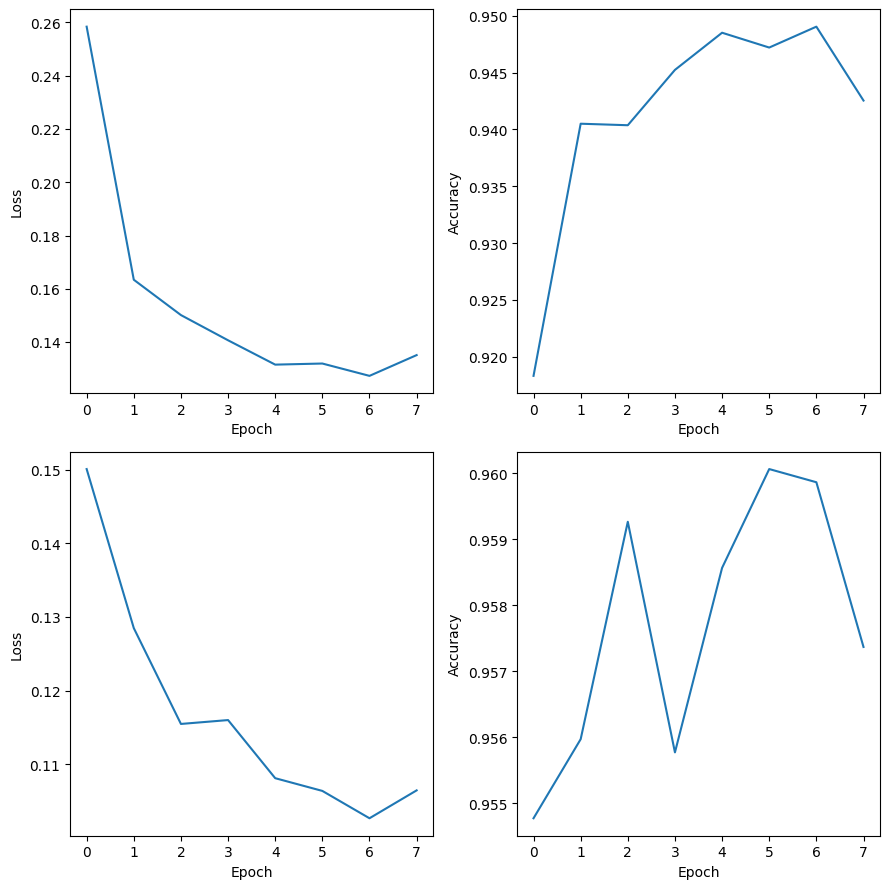

In [47]:
visualize_training_result([stat_loss, stat_acc, test_stat_loss, test_stat_acc])

In [ ]:
def save_model():

  model_path = "/content/drive/MyDrive/model"
  model_name = "Dog_and_Cat_model"
  model_save_path = os.path.join(model_path, model_name)

  torch.save(model.state_dict(), model_save_path)


save_model()

In [ ]:
def load_model(model_path, model):
  weight = torch.load(model_path)
  model.load_state_dict(weight['model_state_dict'])

In [18]:
def load_image(path):

  image_path = []
  class_names = ['Cat', 'Dog']
  for class_name in class_names:
    image_dir = os.path.join(path, class_name)
    image_dir_file = [files for files in os.listdir(image_dir) if  files.lower().endswith('jpg')]

    for image in image_dir_file:
      image_full_path = os.path.join(image_dir, image)
      image_path.append(image_full_path)

  return image_path


In [121]:
def evaluate_model(path, model, num_images=9):
    plt.figure(figsize=(9, 9))

    all_image_path = load_image(path)

    for i in range(num_images):
        idx = random.randint(0, len(all_image_path) - 1)
        image_path = all_image_path[idx]
        image = Image.open(image_path).convert('RGB')
        image_data = image
        class_names = ['Cat','Dog']

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        image_data = transform(image_data).unsqueeze(dim=0).to(device)

        model.eval()
        with torch.inference_mode():
          prediction = model(image_data)
          predicted_class = class_names[prediction.argmax(dim = 1)]

        
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.asarray(image))
        
        if predicted_class == os.path.basename(os.path.dirname(image_path)):
            plt.title(predicted_class, color= "Black")
        else:
            plt.title(predicted_class, color= "Red")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

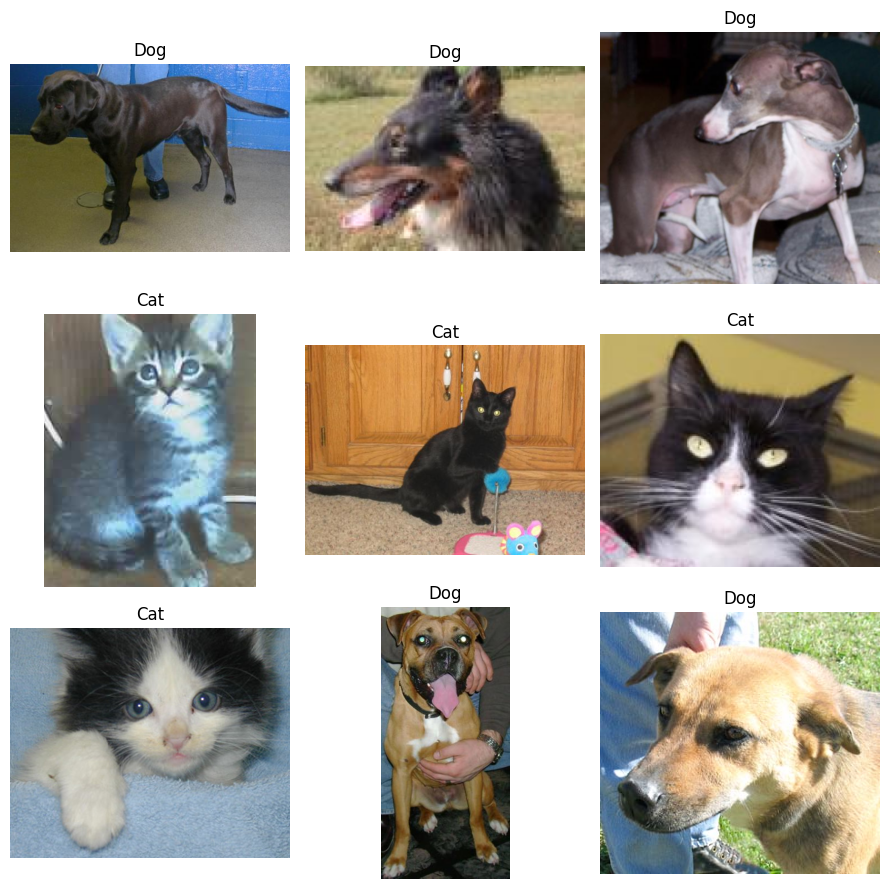

In [129]:
evaluate_model(image_dir, model)